Inspired by https://github.com/aaumaitre/taylor_swift

Dataset from https://www.kaggle.com/pradhanmanva/taylorswiftlyrics
    

Importing Libraries

In [14]:
import pandas as pd
import numpy as np
import tidytext as tt
import matplotlib.pyplot as plt
from nltk.corpus import stopwords

Import Data

In [15]:
lyrics_data = pd.read_csv('./final_taylor_swift_lyrics.tsv', sep='\t')
lyrics_data.head()
# lyrics_data.describe()


,index,album,song_title,lyric,line_number,release_date
0,0,Lover,Lover,[Verse 1],0,2019-08-16
1,0,Lover,Lover,We could leave the Christmas lights up 'til Ja...,1,2019-08-16
2,0,Lover,Lover,"And this is our place, we make the rules",2,2019-08-16
3,0,Lover,Lover,"And there's a dazzling haze, a mysterious way ...",3,2019-08-16
4,0,Lover,Lover,Have I known you 20 seconds or 20 years?,4,2019-08-16


Cleanup data, remove punctuation and lines in []

In [16]:
uniqueValues = lyrics_data['album'].unique()

Disregarding the concert and repackage albums (evermore was sorely missed)

In [17]:
albums = ['folklore', 'Lover', 'reputation', '1989 (Deluxe)', 'Fearless', 'Red', 'Speak Now', 'Taylor Swift']
lyrics_data = lyrics_data[lyrics_data['album'].isin(albums)]
lyrics_data.head()


,index,album,song_title,lyric,line_number,release_date
0,0,Lover,Lover,[Verse 1],0,2019-08-16
1,0,Lover,Lover,We could leave the Christmas lights up 'til Ja...,1,2019-08-16
2,0,Lover,Lover,"And this is our place, we make the rules",2,2019-08-16
3,0,Lover,Lover,"And there's a dazzling haze, a mysterious way ...",3,2019-08-16
4,0,Lover,Lover,Have I known you 20 seconds or 20 years?,4,2019-08-16


In [18]:
lyrics_data = lyrics_data[~lyrics_data.lyric.str.contains('\[')]
lyrics_data = lyrics_data[~lyrics_data.song_title.str.contains('\[')]
#lyrics_data['lyric'] = lyrics_data['lyric'].str.replace('[{}]'.format(string.punctuation), '')
lyrics_data.head()


,index,album,song_title,lyric,line_number,release_date
1,0,Lover,Lover,We could leave the Christmas lights up 'til Ja...,1,2019-08-16
2,0,Lover,Lover,"And this is our place, we make the rules",2,2019-08-16
3,0,Lover,Lover,"And there's a dazzling haze, a mysterious way ...",3,2019-08-16
4,0,Lover,Lover,Have I known you 20 seconds or 20 years?,4,2019-08-16
6,0,Lover,Lover,Can I go where you go?,6,2019-08-16


Lyrics to words

In [19]:
words_data = tt.unnest_tokens(lyrics_data, "word", "lyric")
words_data.head()

,index,album,song_title,line_number,release_date,word
1,0,Lover,Lover,1,2019-08-16,we
1,0,Lover,Lover,1,2019-08-16,could
1,0,Lover,Lover,1,2019-08-16,leave
1,0,Lover,Lover,1,2019-08-16,the
1,0,Lover,Lover,1,2019-08-16,christmas


Get count of words

In [20]:
words_freq = words_data['word'].value_counts()
words_freq

you         1939
i           1925
the         1362
and         1179
me           731
            ... 
humor          1
complex        1
treat          1
stings         1
hipsters       1
Name: word, Length: 2812, dtype: int64


Removing stop words

In [21]:
stop = stopwords.words('english')
#stop = stop.str.replace('[{}]'.format(string.punctuation), '')

words_data['word'] = words_data['word'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
#words_data['word']
words_data['word'].replace('', np.nan, inplace=True)
words_mod_freq = words_data['word'].value_counts().nlargest(15)
words_mod_freq


like     335
know     325
im       313
oh       308
never    260
love     230
dont     217
na       215
cause    188
time     182
back     176
youre    176
want     157
one      157
got      147
Name: word, dtype: int64

Plotting the word frequency

<AxesSubplot:>

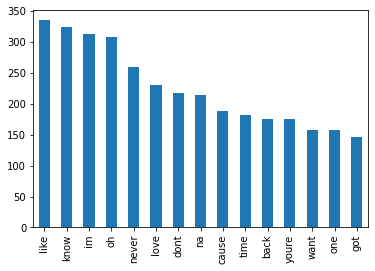

In [22]:
words_mod_freq.plot(kind="bar")

Sentiment Analysis

In [23]:
# from wordcloud import WordCloud 

# df = words_data[words_data.word.notna()]
# print(df.head())
# textt = " ".join(word for word in df.word)
# wordcloud = WordCloud(stopwords=words_mod_freq).generate(textt)
# plt.imshow(wordcloud, interpolation='bilinear')

Get Sentiment Analyser

In [24]:
from nltk.sentiment import SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()


Evalulate sentiment

In [25]:
def valuation_formula(x):
    return max(sia.polarity_scores(x), key=sia.polarity_scores(x).get)

lyrics_data['sentiment'] = lyrics_data.apply(lambda row: valuation_formula(row['lyric']), axis=1)


Visualise sentiment (Sentiment, Album, Freq), classify sentiment of song by couting sentiment of lines

neu         4724
compound     455
pos          166
neg          156
Name: sentiment, dtype: int64

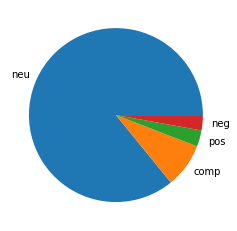

In [26]:
#plotdata = pd.DataFrame(lyrics_data['sentiment'], lyrics_data['album'])
sentiment_freq = lyrics_data['sentiment'].value_counts()
plt.pie(sentiment_freq, labels = ['neu', 'comp', 'pos', 'neg'])
sentiment_freq.head()


Grouping sentiment by song

In [35]:
sent_list = list()

for i in lyrics_data['song_title'].unique():
    y = lyrics_data[lyrics_data['song_title'] == i ].sum().lyric
    m = max(sia.polarity_scores(y)['neg'], sia.polarity_scores(y)['pos'])
    album_name = lyrics_data['album'].where(lyrics_data['song_title'] == i).dropna().values[0]
    val_list = list(sia.polarity_scores(y).values())
    if val_list.index(m) == 2:        
        sent_list.append([i, album_name,'pos', m])
    else:
        sent_list.append([i, album_name,'neg', m])
        
# sent_list


In [36]:
sent_df = pd.DataFrame(sent_list, columns =['song_title', 'album', 'sentiment', 'score'])
sent_df

,song_title,album,sentiment,score
0,Lover,Lover,pos,0.143
1,Look What You Made Me Do,reputation,neg,0.120
2,End Game (Ft. Ed Sheeran & Future),reputation,pos,0.076
3,ME! (Ft. Brendon Urie),Lover,pos,0.178
4,You Need To Calm Down,Lover,pos,0.151
...,...,...,...,...
106,The Outside,Taylor Swift,neg,0.117
107,A Place In This World,Taylor Swift,neg,0.097
108,I Wish You Would (Voice Memo),1989 (Deluxe),pos,0.163
109,A Perfectly Good Heart,Taylor Swift,pos,0.281


In [44]:
sent_df[sent_df.sentiment == 'pos'].sort_values(by=['score'], ascending=False).head()

,song_title,album,sentiment,score
66,This Love,1989 (Deluxe),pos,0.462
80,Sad Beautiful Tragic,Red,pos,0.398
56,It’s Nice to Have a Friend,Lover,pos,0.351
109,A Perfectly Good Heart,Taylor Swift,pos,0.281
62,22,Red,pos,0.267


In [43]:
sent_df[sent_df.sentiment == 'neg'].sort_values(by=['score'], ascending=False).head()

,song_title,album,sentiment,score
54,Shake It Off,1989 (Deluxe),neg,0.353
72,I Wish You Would,1989 (Deluxe),neg,0.232
59,I Knew You Were Trouble,Red,neg,0.229
26,Miss Americana & The Heartbreak Prince,Lover,neg,0.214
51,​hoax,folklore,neg,0.210


Grouping sentiment by album

In [45]:
album_sent_list = list()
for i in lyrics_data['album'].unique():
    album_sent = sent_df['sentiment'].where(sent_df['album'] == i).dropna().values
    (unique, counts) = np.unique(album_sent, return_counts=True)

    frequencies = np.asarray((unique, counts)).T
    album_sent_list.append((i, str(frequencies[0][1]), str(frequencies[1][1]), frequencies[1][1] / frequencies[0][1]))
    
album_sent_list

[('Lover', '6', '12', 2.0),
 ('reputation', '3', '12', 4.0),
 ('1989 (Deluxe)', '6', '13', 2.1666666666666665),
 ('folklore', '9', '7', 0.7777777777777778),
 ('Fearless', '4', '9', 2.25),
 ('Red', '1', '18', 18.0),
 ('Taylor Swift', '3', '8', 2.6666666666666665)]

In [46]:
album_sent_df = pd.DataFrame(album_sent_list, columns = ['album', 'neg', 'pos', 'pos : neg'])
album_sent_df

,album,neg,pos,pos : neg
0,Lover,6,12,2.000000
1,reputation,3,12,4.000000
2,1989 (Deluxe),6,13,2.166667
3,folklore,9,7,0.777778
4,Fearless,4,9,2.250000
5,Red,1,18,18.000000
6,Taylor Swift,3,8,2.666667


Bar graph time

<AxesSubplot:xlabel='album'>

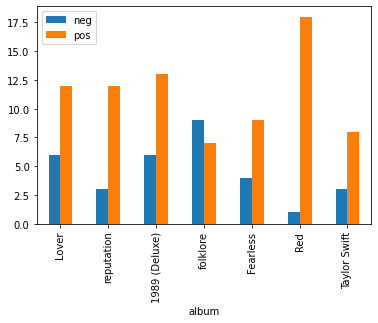

In [47]:
#album_sent_df.plot(x="album", y=["neg", "pos"], kind="bar")
album_sent_df['neg']=album_sent_df['neg'].astype(float)
album_sent_df['pos']=album_sent_df['pos'].astype(float)
album_sent_df[["album", "neg", "pos"]].plot(x="album", kind="bar")

Based on this definitely-not-inaccurate analysis- 
happiest era: Red, 
saddest era: folklore